               f3      target
count  766.000000  766.000000
mean    69.118799    0.349869
std     19.376901    0.477240
min      0.000000    0.000000
25%     62.500000    0.000000
50%     72.000000    0.000000
75%     80.000000    1.000000
max    122.000000    1.000000


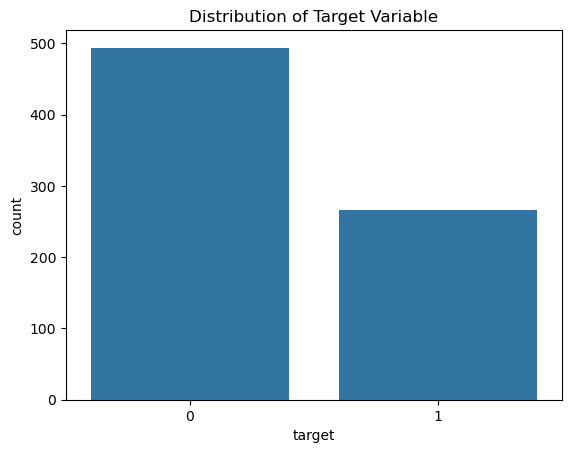

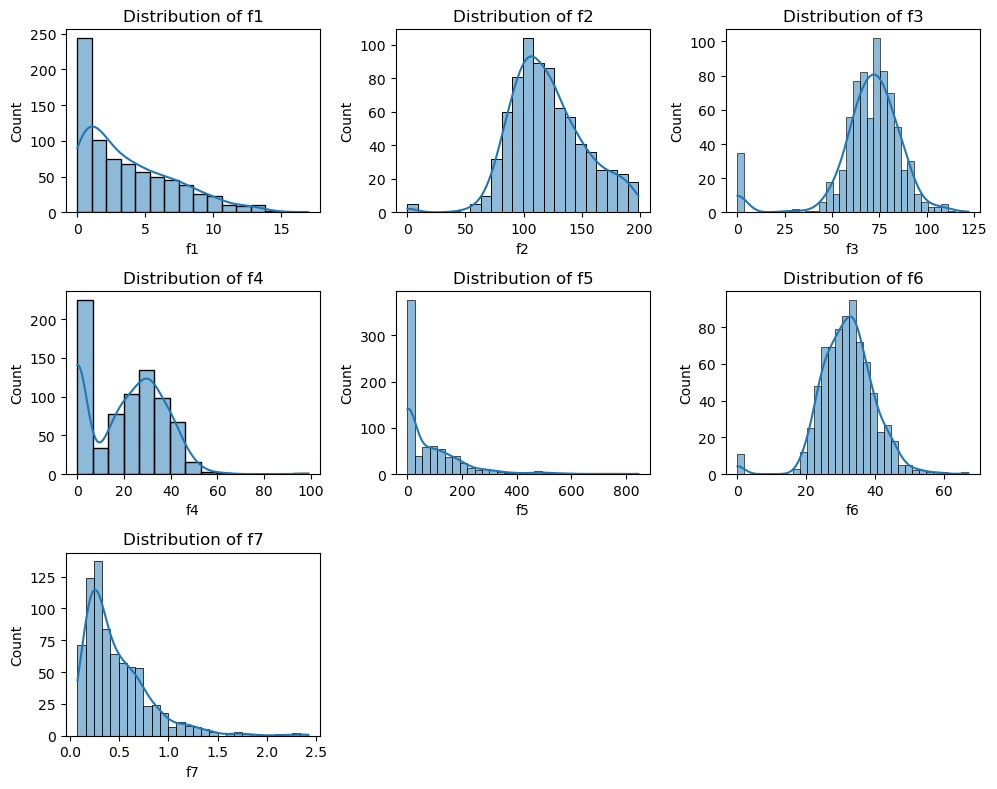

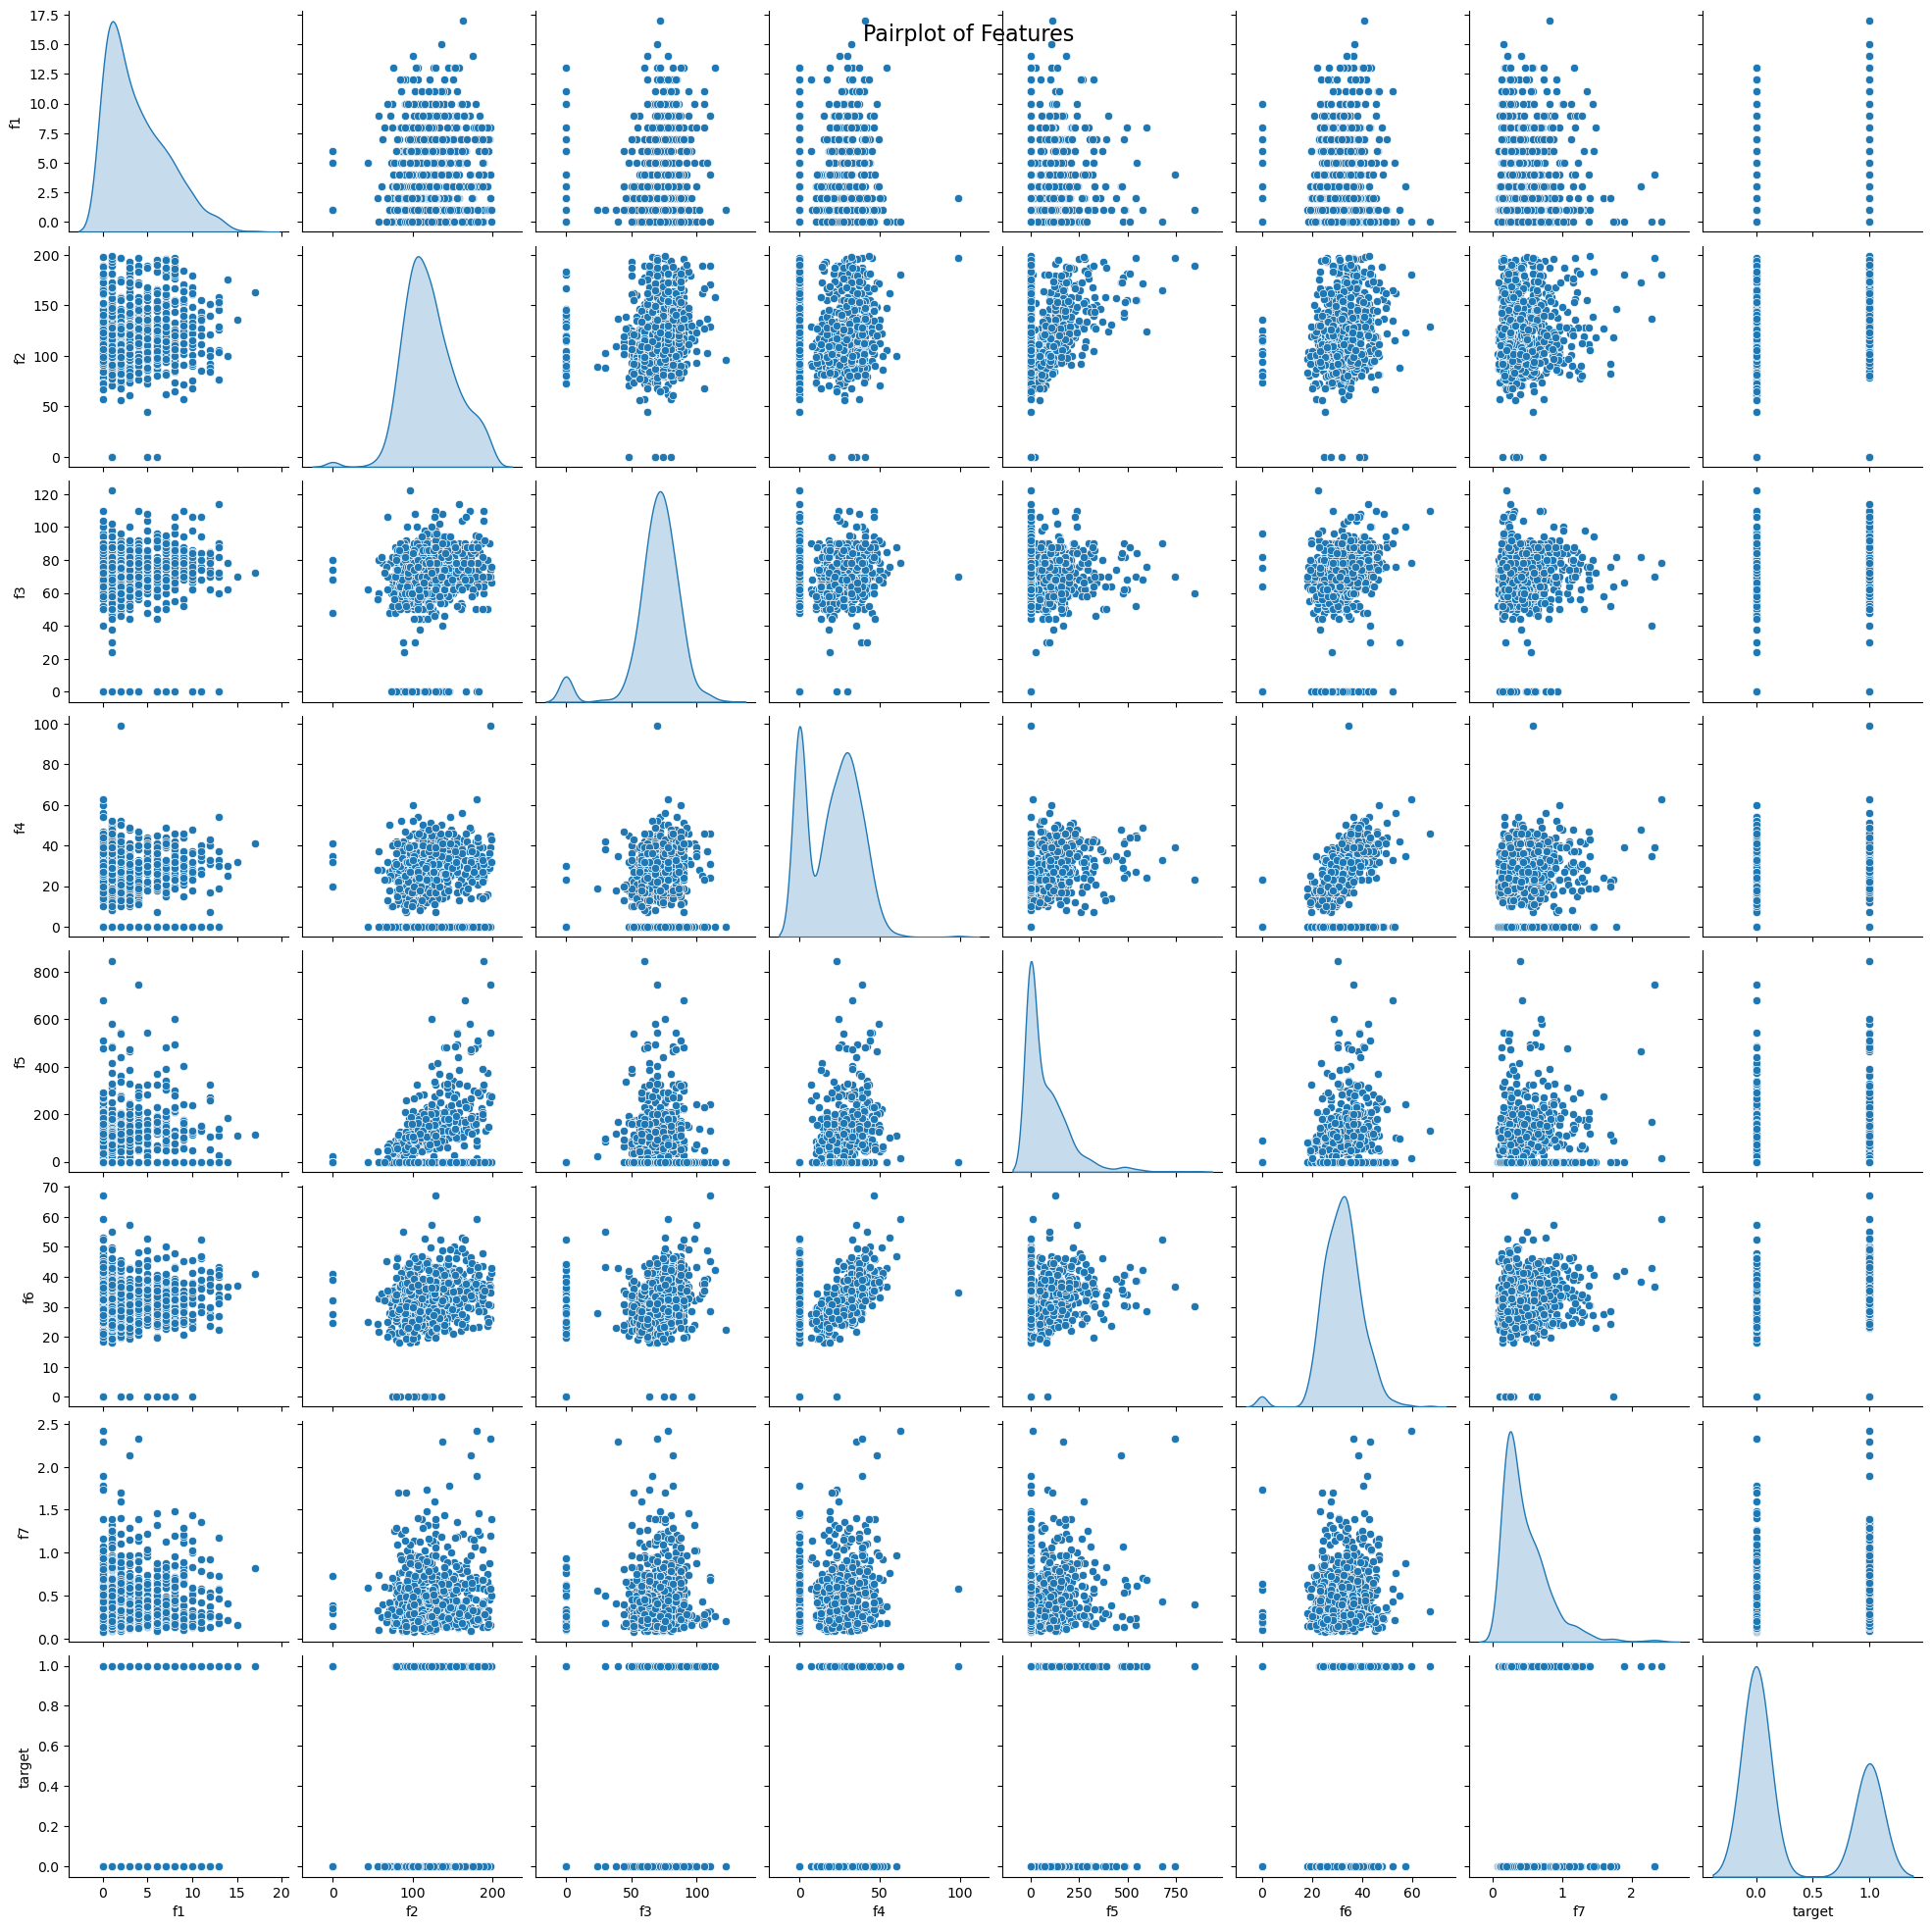

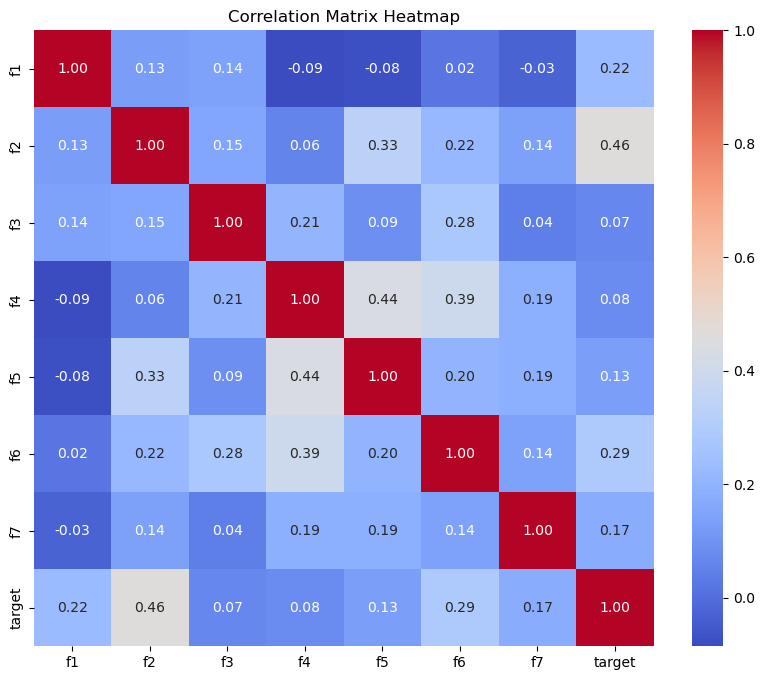

In [36]:
# Step 1: Loading the Dataset and determining Main Statistics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the dataset
dataset = pd.read_csv('dataset.csv')

# Display basic statistics
print(dataset.describe())

# Handling invalid characters by converting to numeric
dataset_cleaned = dataset.map(lambda x: pd.to_numeric(x, errors='coerce'))

# Drop rows with missing values
dataset_cleaned.dropna(inplace=True)

# Visualize the distribution of the target variable
sns.countplot(x='target', data=dataset_cleaned)
plt.title('Distribution of Target Variable')
plt.show()

# Histograms for features
plt.figure(figsize=(10, 8))
for i, column in enumerate(dataset_cleaned.columns[:-1]):  # Exclude 'target' column
    plt.subplot(3, 3, i+1)
    sns.histplot(dataset_cleaned[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()


# Pairplot
def plot_pairplot(dataset):
    sns.pairplot(dataset, diag_kind='kde')
    plt.suptitle('Pairplot of Features', fontsize=16)
    plt.show()

plot_pairplot(dataset_cleaned)

# Step 3 Addition 2: Correlation Matrix Heatmap
def plot_correlation_matrix(dataset):
    corr = dataset.corr()  # Calculate correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
    plt.title('Correlation Matrix Heatmap')
    plt.show()

# Call the function to plot the correlation matrix heatmap
plot_correlation_matrix(dataset_cleaned)


In [8]:
# Step 2: Pre-Processing and Splitting the Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separating
X = dataset_cleaned.drop('target', axis=1)
y = dataset_cleaned['target']

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset into training (70%), validation (15%), and test sets (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


# Converting data to PyTorch tensors
import torch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Printing dataset shapes
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (532, 7)
Validation set shape: (114, 7)
Test set shape: (114, 7)


In [100]:
# Step 3: Define the neural network architecture with Dropout

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(7, 64),     # Input layer with 7 features
            nn.ReLU(),            # Activation function
            nn.Dropout(0.3),      # Dropout layer with 30% dropout rate
            nn.Linear(64, 32),    # Hidden layer
            nn.ReLU(),            # Activation function
            nn.Dropout(0.3),      # Dropout layer with 30% dropout rate
            nn.Linear(32, 1),     # Output layer for binary classification
            nn.Sigmoid()          # Sigmoid for binary classification output
        )

    def forward(self, x):
        return self.model(x)

# Initializing the model
model = NeuralNetwork()
loss_function = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# model summary
print(model)


NeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


Epoch 1/50, Training Loss: 12.4160, Validation Loss: 2.8452, Training Acc: 0.3553, Validation Acc: 0.3772
Epoch 2/50, Training Loss: 11.8413, Validation Loss: 2.7434, Training Acc: 0.5714, Validation Acc: 0.5526
Epoch 3/50, Training Loss: 11.4773, Validation Loss: 2.6501, Training Acc: 0.7481, Validation Acc: 0.7018
Epoch 4/50, Training Loss: 11.0171, Validation Loss: 2.5536, Training Acc: 0.7538, Validation Acc: 0.7018
Epoch 5/50, Training Loss: 10.6643, Validation Loss: 2.4552, Training Acc: 0.7481, Validation Acc: 0.7018
Epoch 6/50, Training Loss: 10.2825, Validation Loss: 2.3634, Training Acc: 0.7519, Validation Acc: 0.6930
Epoch 7/50, Training Loss: 9.7435, Validation Loss: 2.2798, Training Acc: 0.7613, Validation Acc: 0.7018
Epoch 8/50, Training Loss: 9.3707, Validation Loss: 2.2148, Training Acc: 0.7632, Validation Acc: 0.7018
Epoch 9/50, Training Loss: 9.2934, Validation Loss: 2.1628, Training Acc: 0.7726, Validation Acc: 0.7018
Epoch 10/50, Training Loss: 8.9072, Validation Lo

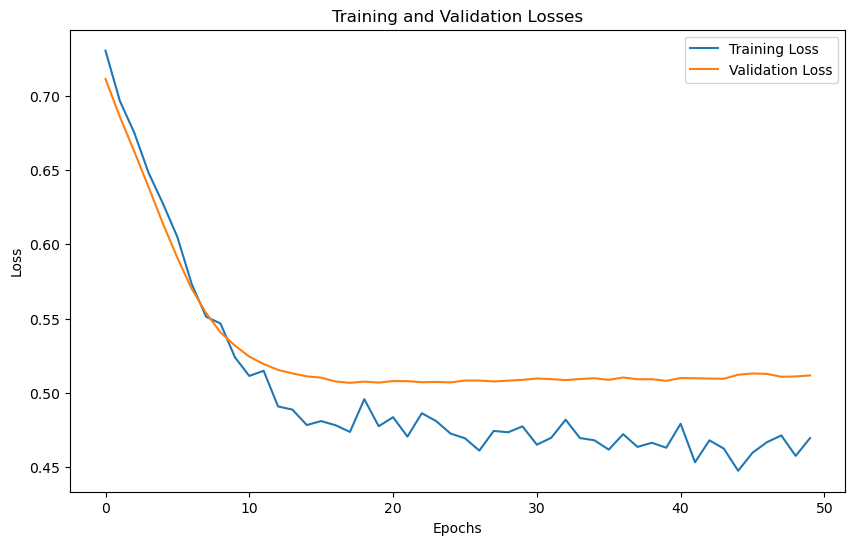

In [102]:

# Helper function to compute accuracy
def compute_accuracy(model, loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Training function with accuracy tracking
def train_model_with_accuracy_tracking(model, train_loader, val_loader, loss_function, optimizer, epochs=50):
     # Initialize accuracy and loss lists
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                val_loss += loss.item()
                
        val_losses.append(val_loss / len(val_loader))

        # training and validation accuracies
        train_acc = compute_accuracy(model, train_loader)
        val_acc = compute_accuracy(model, val_loader)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # losses and accuracies for each epoch
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
              f"Training Acc: {train_acc:.4f}, Validation Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# training the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_accuracy_tracking(
    model, train_loader, val_loader, loss_function, optimizer, epochs=50
)

# DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# visualizing training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Saving weights
torch.save(model.state_dict(), 'gsingh55_assignment2_part_1.pt')


In [106]:
# Function to calculate test loss
def evaluate_test_loss(model, test_loader, loss_function):
    test_loss = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            test_loss += loss.item()
    return test_loss / len(test_loader)  # Return average test loss

test_loss = evaluate_test_loss(model, test_loader, loss_function)

# Evaluating the accuracy on the test set
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def evaluate_model(model, test_loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = torch.round(outputs)  # Rounding sigmoid output
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    print(f'Accuracy on the test set: {test_accuracy * 100:.2f}%')

# Loading the saved model weights
model.load_state_dict(torch.load('gsingh55_assignment2_part_1.pt', weights_only=True))

# accuracy
evaluate_model(model, test_loader)

# Evaluating Precision, Recall, and F1 Score
def evaluate_metrics(model, test_loader):
    preds = []
    labels = []
    
    model.eval()
    with torch.no_grad():
        for inputs, label in test_loader:
            outputs = model(inputs)
            predicted = torch.round(outputs)
            preds.extend(predicted.cpu().numpy())
            labels.extend(label.cpu().numpy())
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    
    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')

evaluate_metrics(model, test_loader)


Accuracy on the test set: 76.32%
Precision: 72.41%
Recall: 52.50%
F1 Score: 60.87%


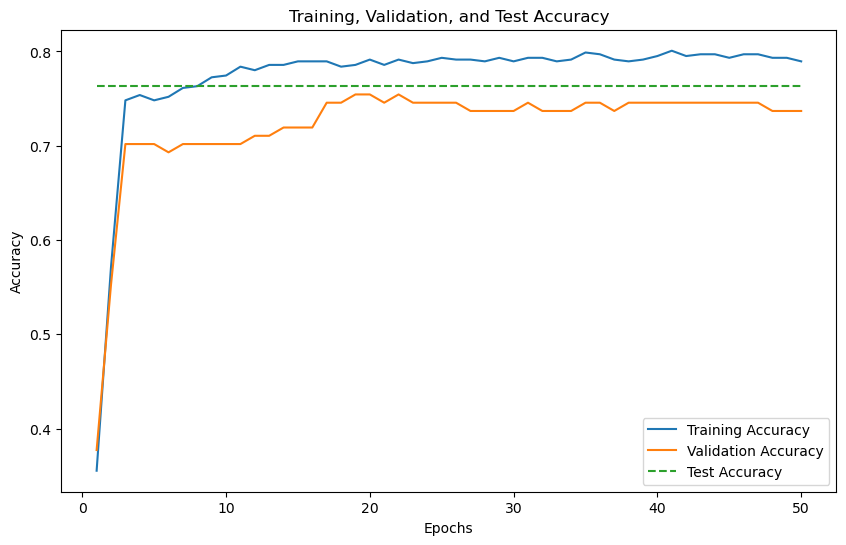

In [110]:
# 7(a) Plot training, validation, and test accuracy
def plot_accuracies(train_accuracies, val_accuracies, test_accuracy, epochs):
    test_accuracies = [test_accuracy] * epochs  # Repeat test accuracy for each epoch
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training, Validation, and Test Accuracy')
    plt.legend()
    plt.show()

plot_accuracies(train_accuracies, val_accuracies, 0.7632, epochs=50)


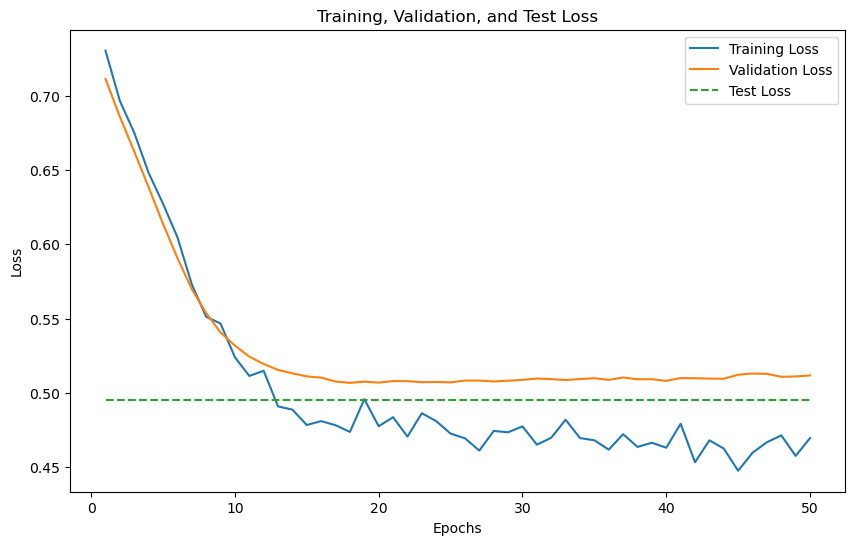

In [112]:
#7(b) training, validation, and test Loss
def plot_losses(train_losses, val_losses, test_loss, epochs):
    test_losses = [test_loss] * epochs  # Repeat test loss for each epoch
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training, Validation, and Test Loss')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses, test_loss, epochs=50)


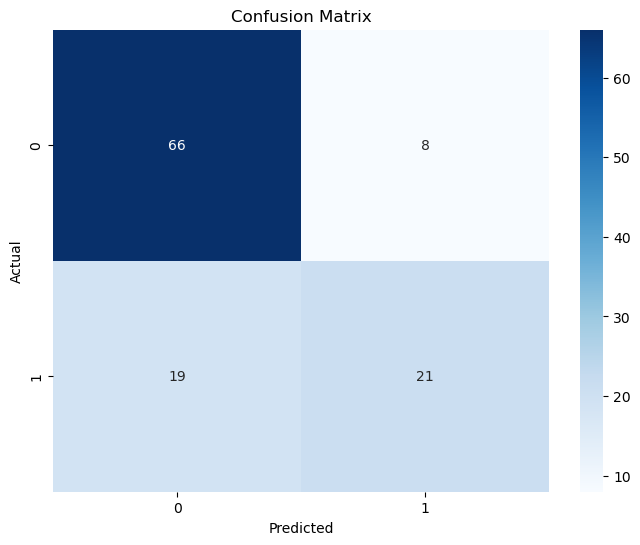

In [120]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 7(c) Confusion Matrix
def plot_confusion_matrix(model, test_loader):
    preds = []
    labels = []
    
    model.eval()
    with torch.no_grad():
        for inputs, label in test_loader:
            outputs = model(inputs)
            predicted = torch.round(outputs)  # Convert sigmoid output to 0 or 1
            preds.extend(predicted.cpu().numpy())
            labels.extend(label.cpu().numpy())
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(labels, preds)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(model, test_loader)


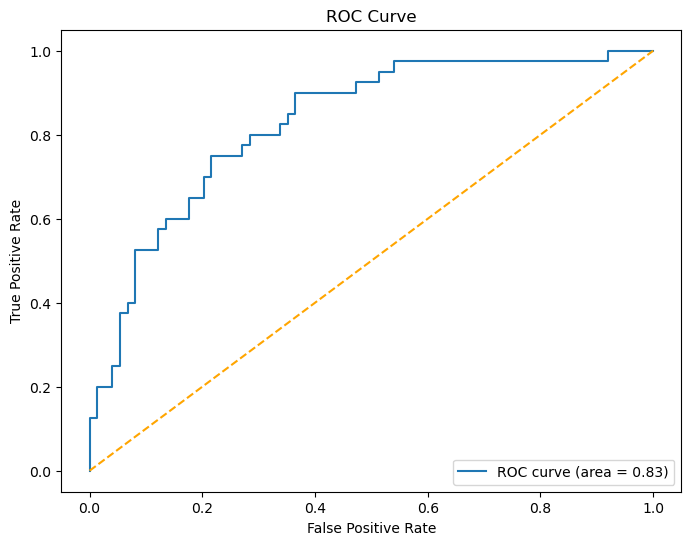

In [124]:
from sklearn.metrics import roc_curve, auc

# 7(d) - ROC Curve and AUC
def plot_roc_curve(model, test_loader):
    preds = []
    labels = []
    
    model.eval()
    with torch.no_grad():
        for inputs, label in test_loader:
            outputs = model(inputs)
            preds.extend(outputs.cpu().numpy())  # Collect raw sigmoid outputs (probabilities)
            labels.extend(label.cpu().numpy())
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)
    
    # Plotting ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(model, test_loader)


### References

1. **Pandas Documentation**:
   - [Pandas Documentation](https://pandas.pydata.org/pandas-docs/stable/)

2. **Matplotlib Documentation**:
   - [Matplotlib Documentation](https://matplotlib.org/stable/contents.html)

3. **Seaborn Documentation**:
   - [Seaborn Documentation](https://seaborn.pydata.org/)

4. **Scikit-learn Documentation**:
   - [Scikit-learn Documentation](https://scikit-learn.org/stable/)

5. **PyTorch Documentation**:
   - [PyTorch Documentation](https://pytorch.org/docs/stable/index.html)

6. **StandardScaler - Scikit-learn**:
   - [StandardScaler Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

7. **Train-Test Split - Scikit-learn**:
   - [Train-Test Split Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

8. **Dropout Layers - PyTorch**:
   - [PyTorch Dropout Documentation](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

9. **Adam Optimizer - PyTorch**:
   - [Adam Optimizer Documentation](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam)
